In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
from datetime import timedelta
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
bk = ox.io.load_graphml('bk.graphml')

In [3]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
ROUTE = 'b8'

In [4]:
trajectories_df = pd.read_csv(f'{EXPORTS_DIR}/trajectories/{ROUTE}_all_trajectories.csv')

In [5]:
bus_ids = set(trajectories_df['bus_id'])
X = 0
Y = 1

In [6]:
def get_trajectories(b_gdf):
    trajectories = []
    curr_bus_id = None
    curr_x = None
    curr_trajectory = []
    LENGTH_THRESHOLD = 10
    trajectories_dict = {}
    
    for i in range(0, len(b_gdf)):
        row = b_gdf.iloc[i]
        lat = row['latitude']
        lon = row['longitude']
        time = row['datetime']
        bus_id = row['bus_id']

        if curr_x == None and curr_bus_id == None:
            curr_x = row['x']
            curr_bus_id = row['bus_id']
            if curr_x == X:
                curr_trajectory.append((lon, lat, time))
        elif row['bus_id'] == curr_bus_id:
            if row['x'] == curr_x:
                if row['x'] == X:
                    curr_trajectory.append((lon, lat, time))
            else:
                if row['x'] == Y:
                    if len(curr_trajectory) > LENGTH_THRESHOLD:
                        if bus_id not in trajectories_dict:
                            trajectories_dict[bus_id] = []
                        trajectories_dict[bus_id].append(curr_trajectory)
                    curr_trajectory = []
                curr_x = row['x']
        else:
            if len(curr_trajectory) > LENGTH_THRESHOLD:
                if bus_id not in trajectories_dict:
                    trajectories_dict[bus_id] = []
                trajectories_dict[bus_id].append(curr_trajectory)
            curr_trajectory = []
            curr_bus_id = row['bus_id']
            curr_x = row['x']
            if curr_x == X:
                curr_trajectory.append((lon, lat, time))
    if len(curr_trajectory) > LENGTH_THRESHOLD:
        if bus_id not in trajectories_dict:
            trajectories_dict[bus_id] = []
        trajectories_dict[bus_id].append(curr_trajectory)
    return trajectories_dict

In [7]:
b_trajectories_dict = get_trajectories(trajectories_df)

In [8]:
# Collect continuous trajectories into ID-grouped dictionary.
#b_trajectories_dict = {}
#for bus_id in bus_ids:
#    df = b_trajectories_gdf[b_trajectories_gdf['bus_id'] == bus_id]
#    direction = df.iloc[0]['x']
#
#    trajectories = []
#    trajectory = []
#
#    for i in range(0, len(df)):
#        row = df.iloc[i]
#        if row['x'] != direction:
#            if direction == 0:
#                trajectories.append(trajectory)
#            trajectory = []
#            direction = row['x']
#
#        (x, y, t) = row[['longitude', 'latitude', 'datetime']]
#        trajectory.append((x, y, t))
#    if direction == 0 and len(trajectory) > 10:
#        display(tr)
#        trajectories.append(trajectory)
#    b_trajectories_dict[bus_id] = trajectories

In [9]:
route_graph = ox.io.load_graphml(f'{EXPORTS_DIR}/graphml/{ROUTE}.graphml')

In [10]:
stops_gdf = gpd.read_file(f'{EXPORTS_DIR}/stops/{ROUTE}_stops.shp').iloc[0:]
stop_edges = ox.nearest_edges(route_graph, stops_gdf['stop_lon'], stops_gdf['stop_lat'])
stop_edge_nodes = [[e[0], e[1]] for e in stop_edges]
route_node_ids_df = pd.read_csv(f'{EXPORTS_DIR}/route_nodes/{ROUTE}_route_nodes.csv')
route_node_ids = route_node_ids_df.iloc[:, 0].tolist()

In [11]:
stops_gdf

,stop_id,JG_C1-Week,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_t,parent_sta,geometry
0,307582,01:00:00,4 AV/95 ST,None,40.616105,-74.031146,None,None,0,None,POINT (-74.03115 40.61610)
1,306945,01:00:28,4 AV/97 ST,None,40.614527,-74.032330,None,None,0,None,POINT (-74.03233 40.61453)
2,308038,01:01:06,FT HAMILTON PKWY/MARINE AV,None,40.613323,-74.030616,None,None,0,None,POINT (-74.03062 40.61332)
3,308039,01:01:39,FT HAMILTON PKY/95 ST,None,40.615101,-74.029071,None,None,0,None,POINT (-74.02907 40.61510)
4,306959,01:02:18,92 ST/FT HAMILTON PY,None,40.616714,-74.027208,None,None,0,None,POINT (-74.02721 40.61671)
...,...,...,...,...,...,...,...,...,...,...,...
75,302723,01:50:43,CHURCH AV/E 96 ST,None,40.655855,-73.915074,None,None,0,None,POINT (-73.91507 40.65586)
76,302724,01:51:00,CHURCH AV/ROCKAWAY PY,None,40.656401,-73.914223,None,None,0,None,POINT (-73.91422 40.65640)
77,307954,01:51:26,E 98 ST/CHURCH AV,None,40.656080,-73.913135,None,None,0,None,POINT (-73.91313 40.65608)
78,307115,01:52:24,HEGEMAN AV/THOMAS S BOYLAND ST,None,40.655881,-73.909480,None,None,0,None,POINT (-73.90948 40.65588)


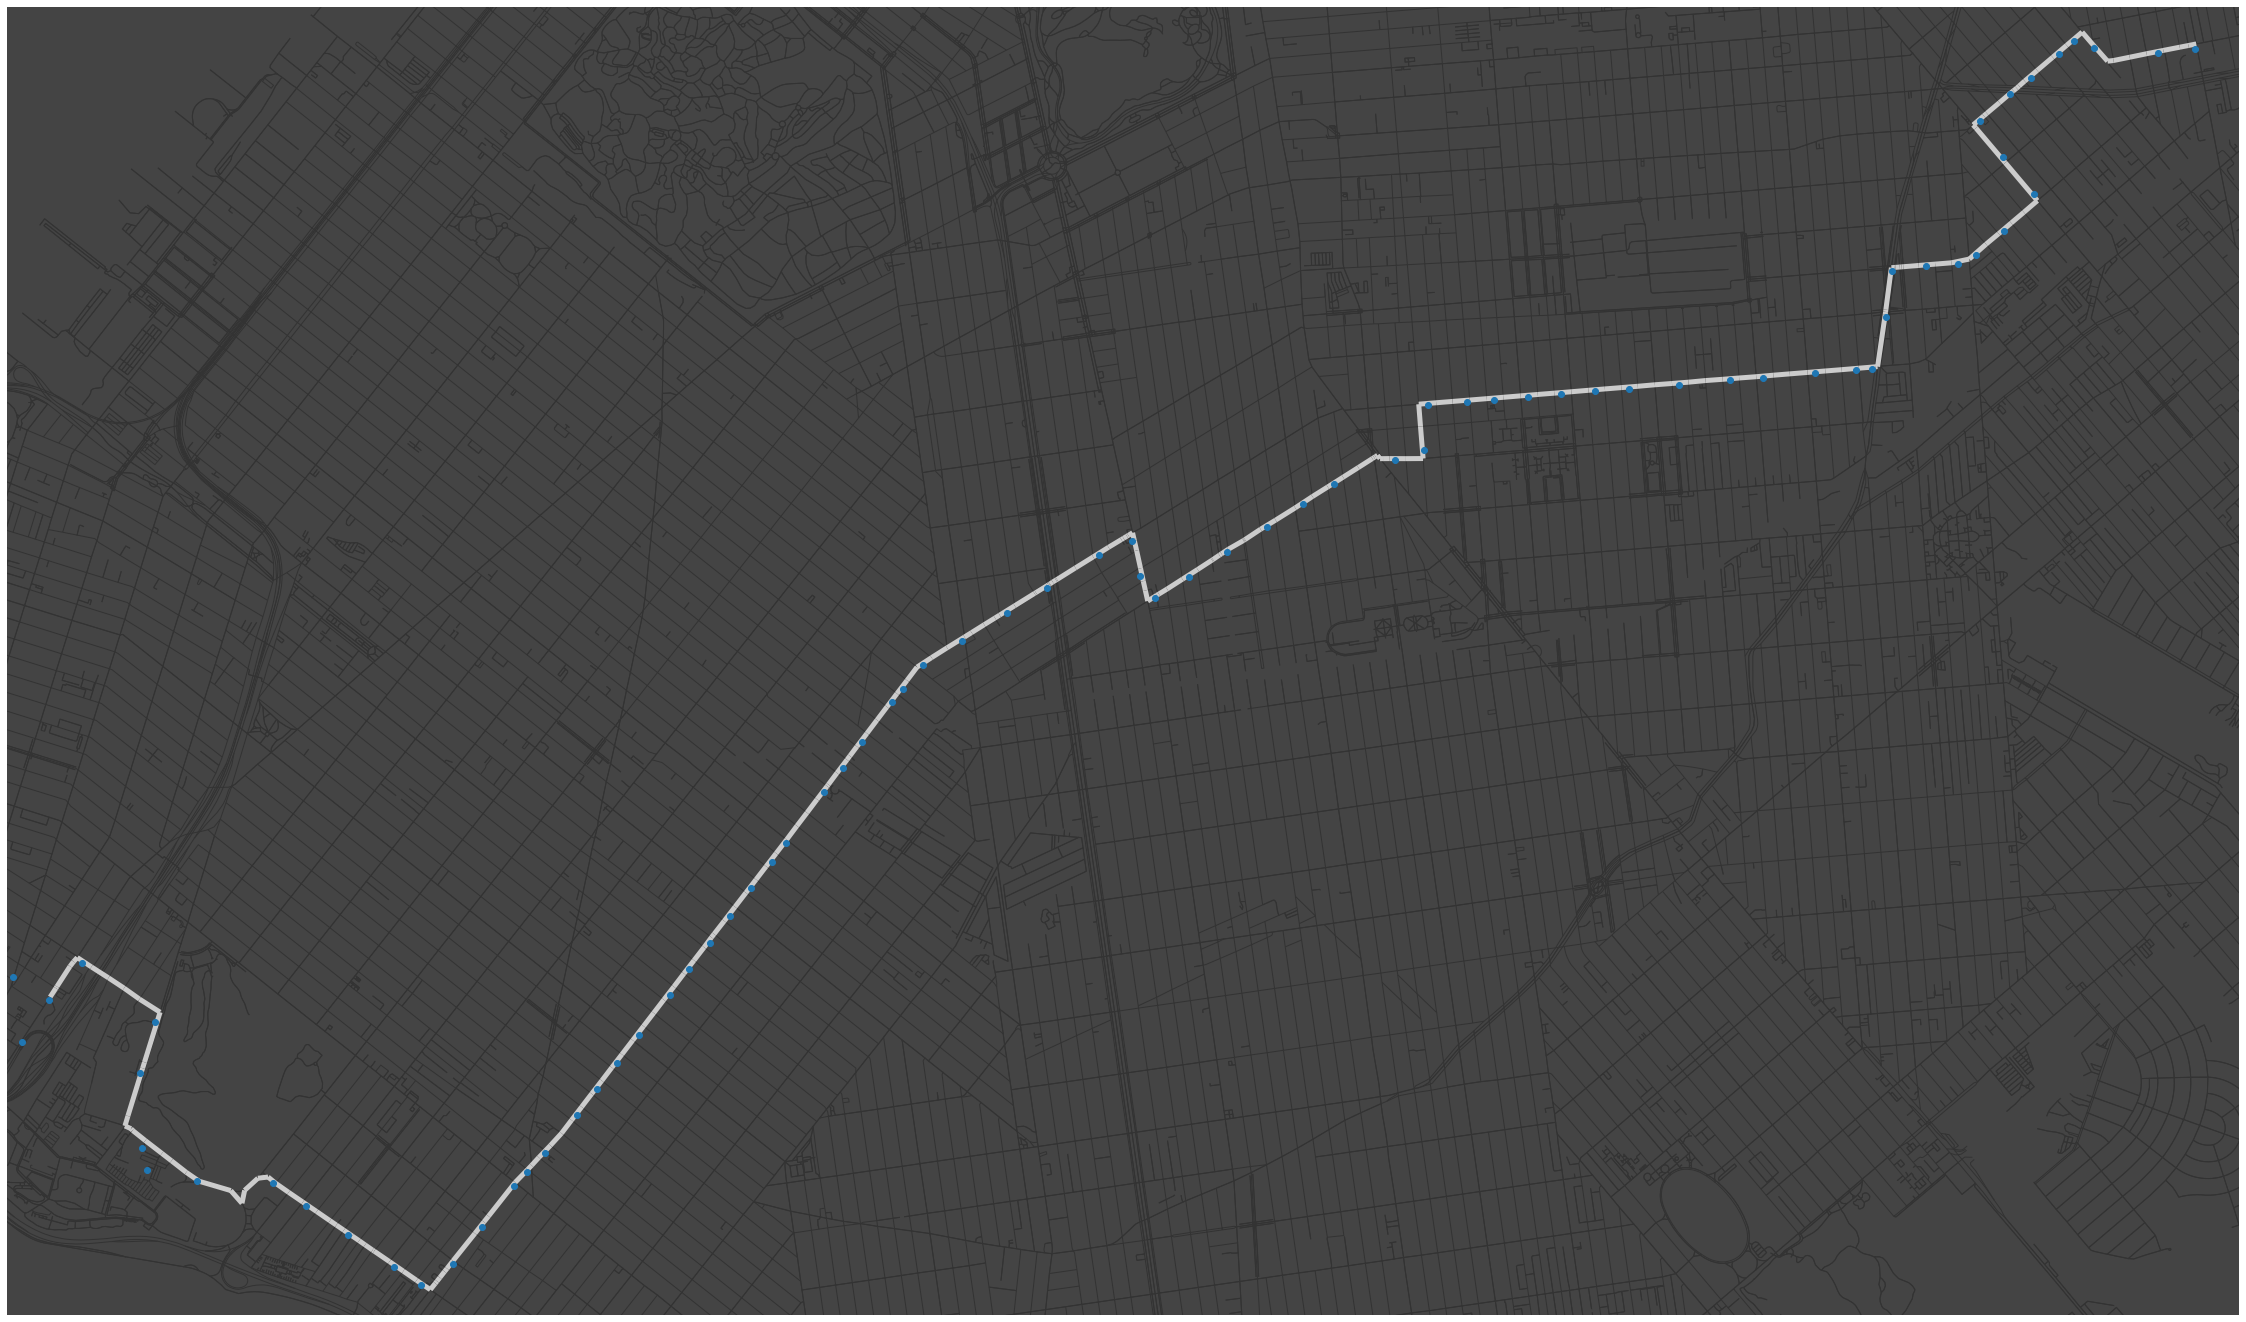

In [12]:
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(bk, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#333')
ox.plot_graph(route_graph, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#ccc', edge_linewidth=5)
stops_gdf.plot(ax=ax)
ax.set_facecolor('#444')

In [13]:
def dedup_consecutive(a):
    b = []
    last = None
    for i in range(0, len(a)):
        c = a[i]
        if c != last:
            last = c
            b.append(c)
    return b

In [14]:
#route = route_gdf.loc[0]

#route_graph_nodes = []
#for i in range(0, len(route_graph_edge_nodes) - 1):
#    edge0 = route_graph_edge_nodes[i]
#    edge1 = route_graph_edge_nodes[i + 1]
#    sp = ox.shortest_path(route_graph, edge0[1], edge1[0])
#    if sp is None:
#        raise Exception('oof')
#    nd = dedup_consecutive(edge0 + sp + [edge1[0]])
#    route_graph_nodes += nd
#
#route_graph_nodes = dedup_consecutive(route_graph_nodes)
#
#display(len(list(route_graph.nodes)))
#display(len(route_node_ids))
#for n in route_node_ids:
#    if n not in route_graph.nodes:
#        print(n)
#print(route_graph.nodes[4619812742])

In [15]:
def snap_to_edge(point, edge):
    p1 = edge[0]
    p2 = edge[1]
    x1 = float(p1[0])
    y1 = float(p1[1])
    x2 = float(p2[0])
    y2 = float(p2[1])
    x3 = point[0]
    y3 = point[1]
    
    m1 = (y2 - y1) / (x2 - x1)
    m3 = -1.0 / m1
    x = (m1 * x1 - m3 * x3 - y1 + y3) / (m1 - m3)
    y = m1 * (x - x1) + y1
    return [x, y]

In [16]:
class RouteNode:
    def __init__(self, i=0, id=0, node=None):
        self.i = i
        self.id = id
        self.node = node
        self.next_node = None
        self.x = node['x']
        self.y = node['y']
        self.t = 0
        self.st = 0
        
    def set_next_node(self, next_node):
        self.next_node = next_node
        self.distance_to_next =ox.distance.euclidean_dist_vec(self.y, self.x, next_node.y, next_node.x)

class Stop:
    def __init__(self, id=0, x=0, y=0, t=0):
        self.id = id
        self.x = x
        self.y = y
        self.t = t
        self.st = 0
        
        self.edge = ox.nearest_edges(route_graph, [self.x], [self.y])[0]
        
        self.prev_node_id = self.edge[0]
        self.next_node_id = self.edge[1]
        self.prev_node_index = route_node_ids.index(self.prev_node_id)
        try:
            self.next_node_index = route_node_ids.index(self.next_node_id, self.prev_node_index)
        except ValueError:
            self.next_node_index = route_node_ids.index(self.next_node_id)
        
        self.prev_node = route_graph.nodes[self.prev_node_id]
        self.next_node = route_graph.nodes[self.next_node_id]
        
        route_point = snap_to_edge([x, y], [[self.prev_node['x'], self.prev_node['y']], [self.next_node['x'], self.next_node['y']]])
        self.rx = route_point[0]
        self.ry = route_point[1]
        
        self.prev_node_dist = ox.distance.euclidean_dist_vec(self.ry, self.rx, self.prev_node['y'], self.prev_node['x'])
        self.next_node_dist = ox.distance.euclidean_dist_vec(self.ry, self.rx, self.next_node['y'], self.next_node['x'])
        
    def get_nearest_edge(self):
        edge = ox.nearest_edges(route_graph, route_gdf['stop_lon'], route_gdf['stop_lat'])
        
class TrajectoryPoint(Stop):
    def __init__(self, i=0, x=0, y=0, t=0):
        super().__init__(i, x, y, t)
        
        next_node_t = route_nodes[self.next_node_index].t
        prev_node_t = route_nodes[self.prev_node_index].t
        
        if next_node_t == 0:
            self.t_expected = None
        elif prev_node_t == 0:
            self.t_expected = None
        else:
            next_node_t -= datetime.timedelta(days=51)
            prev_node_t -= datetime.timedelta(days=51)
            self.t_expected = (self.prev_node_dist / (self.prev_node_dist + self.next_node_dist)) * (next_node_t - prev_node_t) + prev_node_t

In [17]:
route_nodes = []

for i in range(0, len(route_node_ids)):
    id = route_node_ids[i]
    route_nodes.append(RouteNode(i, id, route_graph.nodes[id]))
    
for i in range(0, len(route_node_ids) - 1):
    route_nodes[i].set_next_node(route_nodes[i + 1])

In [18]:
stops = []
stop_dict = {}
for i in range(0, len(stops_gdf)):
    row = stops_gdf.iloc[i]
    stop = Stop(id=int(row['stop_id']), x=row['stop_lon'], y=row['stop_lat'], t=0)#row['departure_'])
    stops.append(stop)
    stop_dict[stop.id] = stop

In [19]:
def calculate_route_node_expected_times(stops):
    for route_node in route_nodes:
        route_node.t = 0
        
    for k in range(0, len(stops) - 1):
        stop = stops[k] 
        stop.next_node_index
        next_stop = stops[k + 1]
        next_stop.prev_node_index

        total_dist = stop.next_node_dist
        for i in range(stop.next_node_index, next_stop.prev_node_index + 1):
            total_dist += route_nodes[i].distance_to_next
        total_dist += next_stop.prev_node_dist
        t0 = stop.t
        t1 = next_stop.t

        for i in range(stop.next_node_index, next_stop.prev_node_index + 1):
            node_dist = 0
            for j in range(i, next_stop.prev_node_index + 1):
                node_dist += route_nodes[j].distance_to_next
            node_dist += next_stop.prev_node_dist

            ratio = (total_dist - node_dist) / total_dist
            route_nodes[i].t = (t1 - t0) * ratio + t0

In [20]:
def calculate_route_node_actual_times(trajectory_points):
    # Calculate the actual time at each route node based on the trajectory times.
    for route_node in route_nodes:
        route_node.st = 0
        
    for k in range(0, len(trajectory_points) - 1):
        trajectory_point = trajectory_points[k] 
        trajectory_point.next_node_index
        next_trajectory_point = trajectory_points[k + 1]
        next_trajectory_point.prev_node_index

        total_dist = trajectory_point.next_node_dist
        for i in range(trajectory_point.next_node_index, next_trajectory_point.prev_node_index + 1):
            total_dist += route_nodes[i].distance_to_next
        total_dist += next_trajectory_point.prev_node_dist
        t0 = trajectory_point.t
        t1 = next_trajectory_point.t

        for i in range(trajectory_point.next_node_index, next_trajectory_point.prev_node_index + 1):
            node_dist = 0
            for j in range(i, next_trajectory_point.prev_node_index + 1):
                node_dist += route_nodes[j].distance_to_next
            node_dist += next_trajectory_point.prev_node_dist

            ratio = (total_dist - node_dist) / total_dist
            route_nodes[i].st = (t1 - t0) * ratio + t0

In [21]:
def calculate_stop_actual_times(trajectory_points):
    # Calculate the actual time at each stop based on the trajectory times.
    for stop in stops:
        stop.st = 0
    for k in range(0, len(stops) - 1):
        stop = stops[k]
        stop_prev_node = route_nodes[stop.prev_node_index]
        stop_next_node = route_nodes[stop.next_node_index]
        if stop_prev_node.st != 0 and stop_next_node.st != 0:
            ratio = stop.prev_node_dist / (stop.prev_node_dist + stop.next_node_dist)
            t0 = stop_prev_node.st
            t1 = stop_next_node.st
            stop.st = (t1 - t0) * ratio + t0

In [22]:
def plot(trajectory_points):
    fig, ax = plt.subplots(figsize=(40, 30))
    ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=10, node_color='black', show=False, close=False)

    X = [route_graph.nodes[n]['x'] for n in route_node_ids]
    Y = [route_graph.nodes[n]['y'] for n in route_node_ids]
    ax.scatter(X, Y, color='black')
    
    for i in range(0, len(route_nodes)):
        x = X[i]
        y = Y[i]
        k = 1 if i % 2 == 0 else -4
        route_node = route_nodes[i]
        if route_node.st != None and route_node.st != 0:
            ax.annotate(route_node.st.strftime('%H:%M'), (x, y),
                       xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='black')

    X = [t.rx for t in stops]
    Y = [t.ry for t in stops]
    ax.scatter(X, Y, color='red')

    for i in range(0, len(stops)):
        x = X[i]
        y = Y[i]
        k = 1 if i % 2 == 0 else -4
        stop = stops[i]
        if stop.st != None and stop.st != 0:
            ax.annotate(stop.st.strftime('%H:%M'), (x, y),
                       xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='red')

    X = [t.rx for t in trajectory_points]
    Y = [t.ry for t in trajectory_points]
    ax.scatter(X, Y, color='blue')

    for i in range(0, len(trajectory_points)):
        x = X[i]
        y = Y[i]
        k = 1 if i % 2 == 0 else -4
        tp = trajectory_points[i]
        if tp.t != 0:
            ax.annotate(tp.t.strftime('%H:%M'), (x, y),
                       xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='blue')

    plt.show()

In [23]:
stop_times_df = pd.read_csv(f'{EXPORTS_DIR}/stop_times/{ROUTE}_weekday_stop_times.csv')
stop_times_df

,trip_id,307582,306945,308038,308039,306959,305951,305952,308357,308358,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,JG_C1-Weekday-SDon-006000_B8_102,01:00:00,01:00:28,01:01:06,01:01:39,01:02:18,01:03:25,01:04:01,01:05:00,01:05:16,...,01:47:54,01:48:34,01:49:17,01:49:51,01:50:12,01:50:43,01:51:00,01:51:26,01:52:24,01:53:00
1,JG_C1-Weekday-012000_B8_101,02:00:00,02:00:28,02:01:06,02:01:39,02:02:18,02:03:25,02:04:01,02:05:00,02:05:16,...,02:47:54,02:48:34,02:49:17,02:49:51,02:50:12,02:50:43,02:51:00,02:51:26,02:52:24,02:53:00
2,JG_C1-Weekday-SDon-018000_B8_102,03:00:00,03:00:28,03:01:06,03:01:39,03:02:18,03:03:25,03:04:01,03:05:00,03:05:16,...,03:47:54,03:48:34,03:49:17,03:49:51,03:50:12,03:50:43,03:51:00,03:51:26,03:52:24,03:53:00
3,JG_C1-Weekday-SDon-024000_B8_104,04:00:00,04:00:28,04:01:06,04:01:39,04:02:18,04:03:25,04:04:01,04:05:00,04:05:16,...,04:50:54,04:51:34,04:52:17,04:52:51,04:53:12,04:53:43,04:54:00,04:54:26,04:55:24,04:56:00
4,JG_C1-Weekday-028500_B8_108,04:45:00,04:45:28,04:46:06,04:46:39,04:47:18,04:48:25,04:49:01,04:50:00,04:50:16,...,05:39:12,05:40:06,05:41:03,05:41:48,05:42:17,05:42:58,05:43:20,05:43:54,05:45:11,05:46:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,JG_C1-Weekday-132400_B8_150,22:04:00,22:04:28,22:05:06,22:05:39,22:06:18,22:07:25,22:08:01,22:09:00,22:09:16,...,23:02:20,23:03:05,23:03:52,23:04:30,23:04:54,23:05:28,23:05:46,23:06:15,23:07:20,23:08:00
73,JG_C1-Weekday-134900_B8_145,22:29:00,22:29:28,22:30:06,22:30:39,22:31:18,22:32:25,22:33:01,22:34:00,22:34:16,...,23:27:20,23:28:05,23:28:52,23:29:30,23:29:54,23:30:28,23:30:46,23:31:15,23:32:20,23:33:00
74,JG_C1-Weekday-137400_B8_148,22:54:00,22:54:28,22:55:06,22:55:39,22:56:18,22:57:25,22:58:01,22:59:00,22:59:16,...,23:52:20,23:53:05,23:53:52,23:54:30,23:54:54,23:55:28,23:55:46,23:56:15,23:57:20,23:58:00
75,JG_C1-Weekday-139900_B8_149,23:19:00,23:19:28,23:20:06,23:20:39,23:21:18,23:22:25,23:23:01,23:24:00,23:24:16,...,24:17:20,24:18:05,24:18:52,24:19:30,24:19:54,24:20:28,24:20:46,24:21:15,24:22:20,24:23:00


In [24]:
stops_gdf

,stop_id,JG_C1-Week,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_t,parent_sta,geometry
0,307582,01:00:00,4 AV/95 ST,None,40.616105,-74.031146,None,None,0,None,POINT (-74.03115 40.61610)
1,306945,01:00:28,4 AV/97 ST,None,40.614527,-74.032330,None,None,0,None,POINT (-74.03233 40.61453)
2,308038,01:01:06,FT HAMILTON PKWY/MARINE AV,None,40.613323,-74.030616,None,None,0,None,POINT (-74.03062 40.61332)
3,308039,01:01:39,FT HAMILTON PKY/95 ST,None,40.615101,-74.029071,None,None,0,None,POINT (-74.02907 40.61510)
4,306959,01:02:18,92 ST/FT HAMILTON PY,None,40.616714,-74.027208,None,None,0,None,POINT (-74.02721 40.61671)
...,...,...,...,...,...,...,...,...,...,...,...
75,302723,01:50:43,CHURCH AV/E 96 ST,None,40.655855,-73.915074,None,None,0,None,POINT (-73.91507 40.65586)
76,302724,01:51:00,CHURCH AV/ROCKAWAY PY,None,40.656401,-73.914223,None,None,0,None,POINT (-73.91422 40.65640)
77,307954,01:51:26,E 98 ST/CHURCH AV,None,40.656080,-73.913135,None,None,0,None,POINT (-73.91313 40.65608)
78,307115,01:52:24,HEGEMAN AV/THOMAS S BOYLAND ST,None,40.655881,-73.909480,None,None,0,None,POINT (-73.90948 40.65588)


In [25]:
def dt_string_to_seconds(dt_string):
    if dt_string is None:
        return np.nan
    hours = int(dt_string[0:2])
    minutes = int(dt_string[3:5])
    seconds = int(dt_string[6:8])
    return hours * 24 * 60 + minutes * 60 + seconds

def calculate_time_diff(matched_df):
    return matched_df.iloc[:, 3:-3].applymap(dt_string_to_seconds).diff(1).iloc[1, :]

In [26]:
tx = list(b_trajectories_dict.values())[0][0]
tps = [
    TrajectoryPoint(i=0,
                    x=x,
                    y=y,
                    t=datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S'))
    for (x, y, t) in tx
]

In [27]:
calculate_route_node_actual_times(tps)
calculate_stop_actual_times(tps)

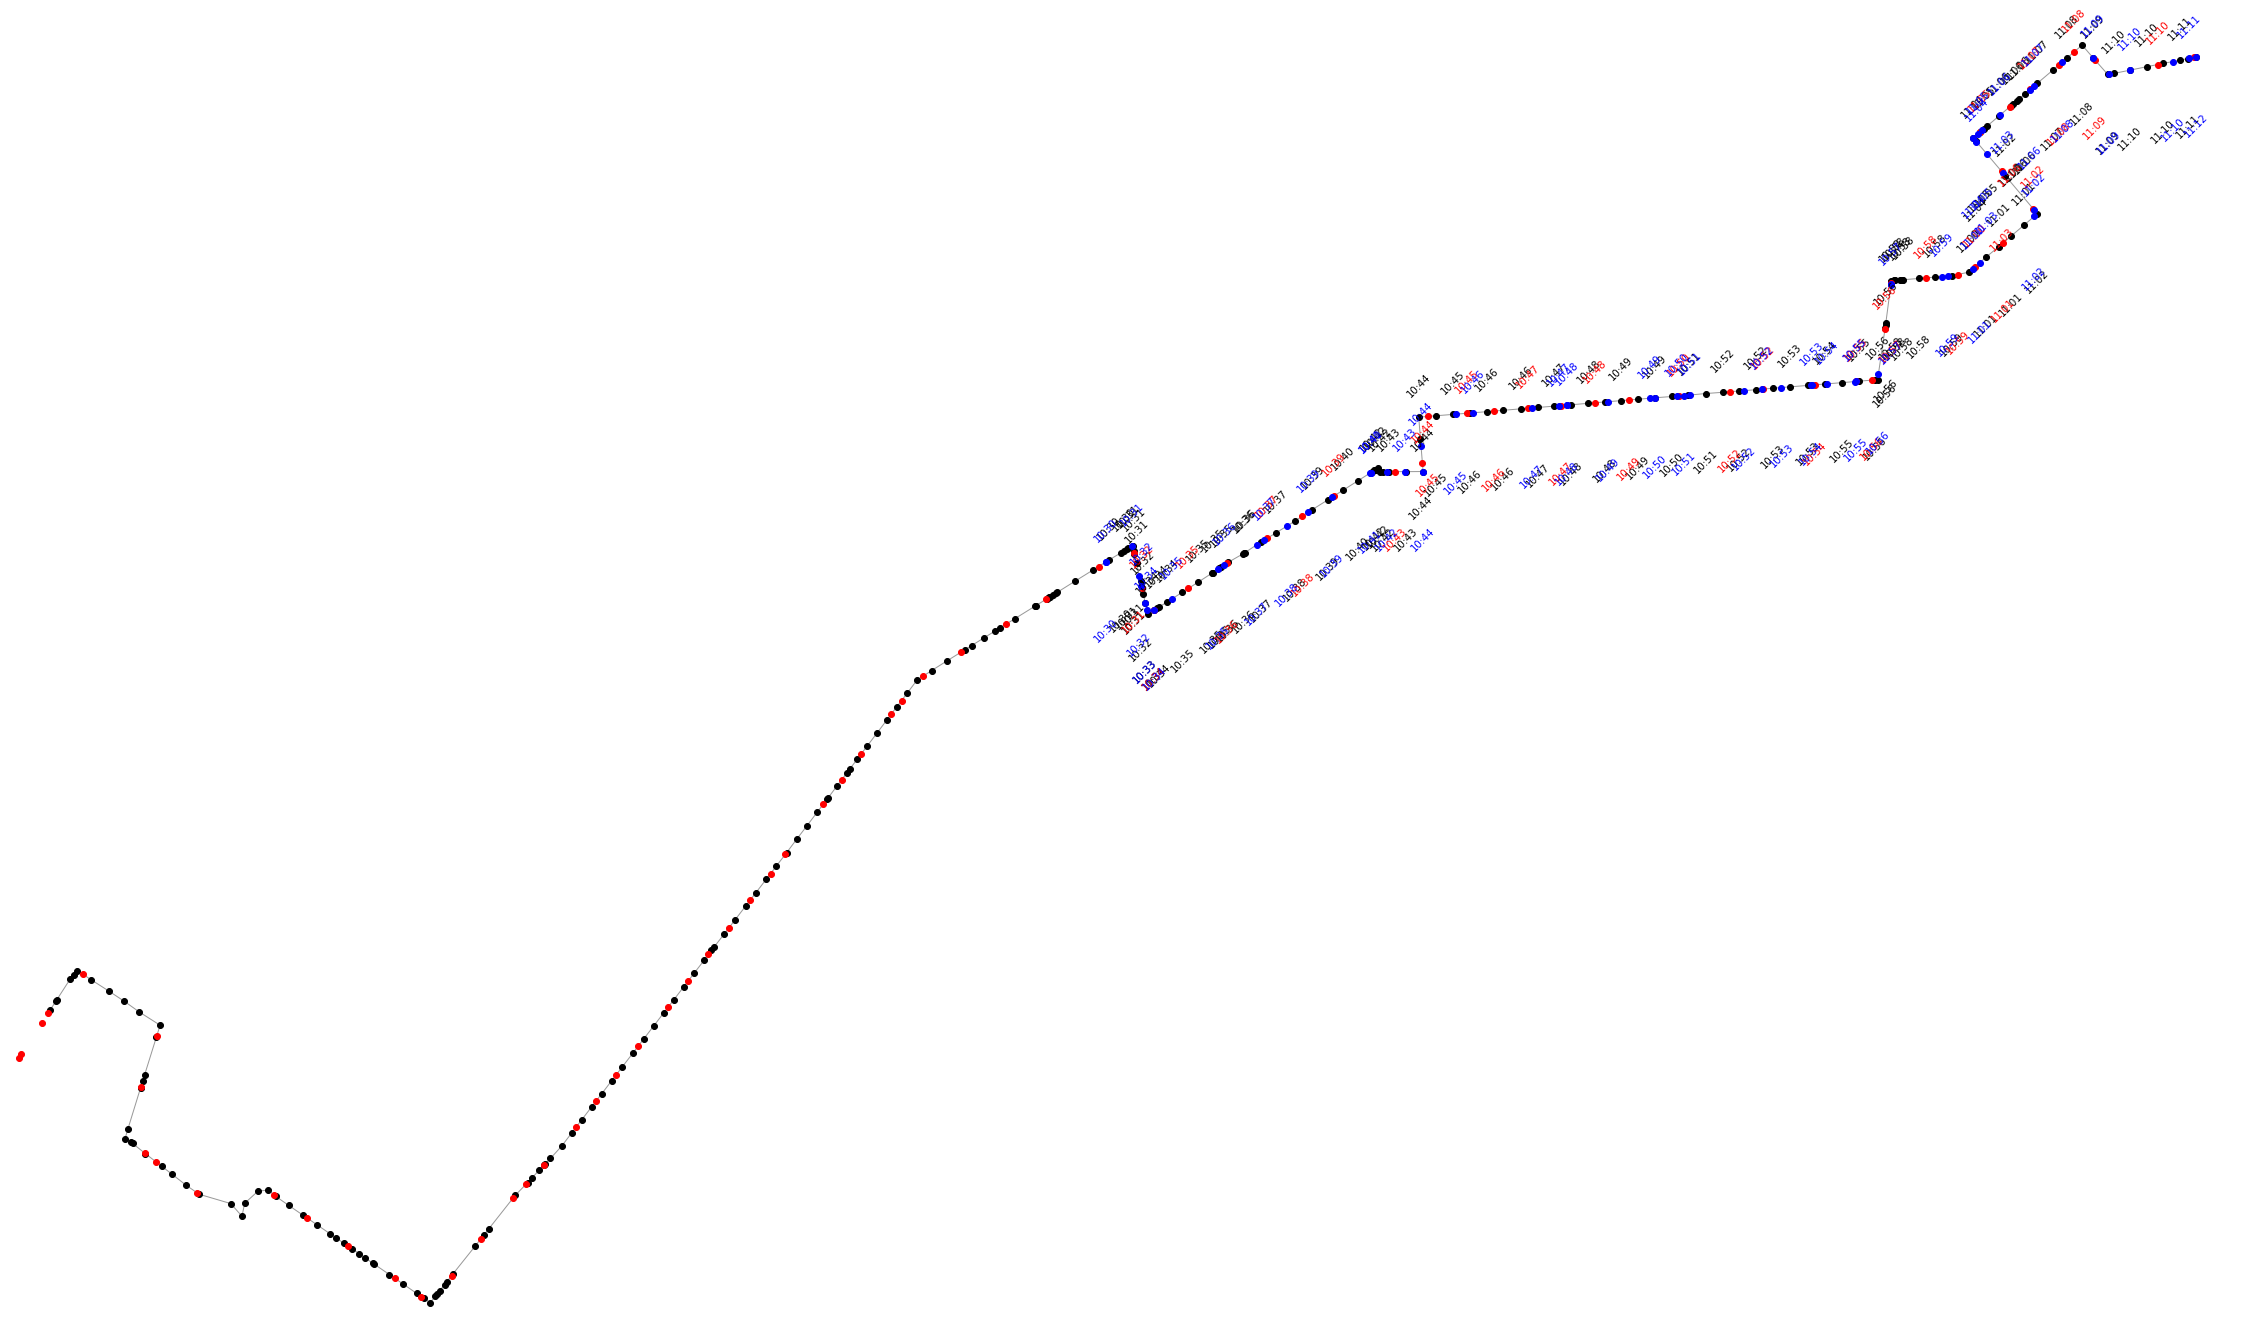

In [28]:
plot(tps)

In [29]:
def to_datetime(dt):
    if dt is None:
        return None
    if dt[0:2] == '24':
        dt2 = pd.to_datetime('00' + dt[2:], format='%H:%M:%S') + timedelta(days=1)
    else:
        dt2 = pd.to_datetime(dt, format='%H:%M:%S')
    return dt2

def find_closest_schedule(start_index=1, end_index=-3):
    columns = list(stops_gdf['stop_id'])
    route_actual_times = pd.DataFrame(
        {
            column: [stop.st.strftime('%H:%M:%S') if stop.st != 0 else None]
            for (column, stop) in zip(columns, stops)
        },
        columns=columns)
    display(route_actual_times)
    
    start_col = route_actual_times.columns[start_index]
    actual_start_time = to_datetime(route_actual_times[start_col].iloc[0])
    
    if actual_start_time == None:
        return None

    end_col = route_actual_times.columns[end_index]
    actual_end_time = to_datetime(route_actual_times[end_col].iloc[0])
    if actual_end_time == None:
        return None
    
    stop_diffs_df = stop_times_df.copy()[['trip_id', str(start_col)]]
    stop_diffs_df[str(start_col)] = stop_diffs_df[str(start_col)].apply(to_datetime)
    stop_diffs_df['diff'] = stop_diffs_df[str(start_col)] - actual_start_time
    threshold = 5
    matching_df = stop_diffs_df[
        (stop_diffs_df['diff'] < timedelta(minutes=5)) &
        (stop_diffs_df['diff'] > timedelta(minutes=-20))]
    matching_trips = list(matching_df['trip_id'])
    
    matching_dfs = [stop_times_df[stop_times_df['trip_id'] == t] for t in matching_trips]

    return matching_dfs

In [30]:
START_INDEX = 5
END_INDEX = -5

diff_rows = []
for bus_id, trajectories in tqdm(list(b_trajectories_dict.items())[0:5]):
    for trajectory in trajectories:
        if len(trajectory) < 10:
            continue
        trajectory_points = [
            TrajectoryPoint(i=0,
                            x=x,
                            y=y,
                            t=datetime.datetime.strptime(
                                t, '%Y-%m-%d %H:%M:%S'))
            for (x, y, t) in trajectory
        ]
        calculate_route_node_actual_times(trajectory_points)
        calculate_stop_actual_times(trajectory_points)
        matched_dfs = find_closest_schedule(START_INDEX, END_INDEX)
        if matched_dfs is not None:
            min_diff_df = None
            min_diff_sum = 2**16
            min_trip_id = None
            for matched_df in matched_dfs:
                expected_stops = []
                for i in range(START_INDEX, len(matched_df.columns) + END_INDEX):
                    matching_stop = stop_dict[int(matched_df.columns[i])]
                    x = matching_stop.x
                    y = matching_stop.y
                    matched_df.iloc[0, i] = to_datetime(matched_df.iloc[0, i])
                    t = pd.to_datetime(matched_df.iloc[0, i])
                    expected_stop = Stop(id=matching_stop.id, x=x, y=y, t=t)
                    expected_stops.append(expected_stop)

                try:
                    calculate_route_node_expected_times(expected_stops)
                except TypeError:
                    print(f'Error at {bus_id}')
                    continue

                df_dict = {n.id: n.t for n in route_nodes if n.t != 0 and n.st != 0}
                expected_df = pd.DataFrame([df_dict], columns=df_dict.keys())
                df_dict = {
                    n.id: n.st for n in route_nodes if n.t != 0 and n.st != 0
                }
                actual_df = pd.DataFrame([df_dict], columns=df_dict.keys())

                expected_df = expected_df.applymap(lambda x: x.strftime('%H:%M:%S'))
                actual_df = actual_df.applymap(lambda x: x.strftime('%H:%M:%S'))
                diff_df = calculate_time_diff(pd.concat([expected_df, actual_df]))
                diff_sum = diff_df.abs().sum()
                trip_id = matched_df.iloc[0, 0]
                if diff_sum < min_diff_sum:
                    diff_sum = min_diff_sum
                    min_diff_df = diff_df
                    min_trip_id = trip_id
            if min_diff_df is not None:
                diff_rows.append([min_trip_id, min_diff_df])
            #break

  0%|          | 0/5 [00:00<?, ?it/s]

,307582,306945,308038,308039,306959,305951,305952,308357,308358,307313,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,None,None,None,None,None,None,None,None,None,None,...,11:02:13,11:03:08,11:05:28,11:06:30,11:07:02,11:08:08,11:08:41,11:09:29,11:10:42,None


,307582,306945,308038,308039,306959,305951,305952,308357,308358,307313,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,None,None,None,None,14:10:09,14:12:47,14:13:54,14:15:05,14:15:40,14:16:25,...,15:24:28,15:25:34,15:28:25,15:29:44,15:30:33,15:32:12,15:33:13,15:33:44,15:35:18,None


,307582,306945,308038,308039,306959,305951,305952,308357,308358,307313,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,None,None,None,None,18:44:35,18:46:56,18:47:26,18:48:08,18:48:43,18:49:29,...,20:03:35,20:04:36,20:05:52,20:06:38,20:07:17,20:08:10,20:09:05,20:09:48,20:11:10,None


 20%|██        | 1/5 [00:24<01:38, 24.68s/it]

,307582,306945,308038,308039,306959,305951,305952,308357,308358,307313,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,None,None,None,None,21:44:52,21:46:43,21:47:17,21:48:18,21:48:54,21:49:36,...,22:48:31,22:49:23,22:51:34,22:52:51,22:53:45,22:54:50,22:56:01,22:57:23,22:58:31,None


 40%|████      | 2/5 [00:33<00:46, 15.57s/it]

,307582,306945,308038,308039,306959,305951,305952,308357,308358,307313,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,None,None,None,None,05:14:34,05:15:48,05:16:18,05:17:00,05:17:31,05:17:59,...,06:07:23,06:08:43,06:09:51,06:11:09,06:11:34,06:12:44,06:13:34,06:14:03,06:15:12,None


 60%|██████    | 3/5 [00:42<00:25, 12.53s/it]

,307582,306945,308038,308039,306959,305951,305952,308357,308358,307313,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


,307582,306945,308038,308039,306959,305951,305952,308357,308358,307313,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,None,None,None,None,17:00:50,17:05:34,17:05:41,17:07:25,17:07:36,17:07:44,...,18:28:17,18:29:23,18:31:39,18:33:30,18:34:14,18:37:06,18:38:06,18:39:22,02:30:23,None


 80%|████████  | 4/5 [00:59<00:14, 14.38s/it]

,307582,306945,308038,308039,306959,305951,305952,308357,308358,307313,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


,307582,306945,308038,308039,306959,305951,305952,308357,308358,307313,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,None,None,None,None,09:05:27,09:09:18,09:10:10,09:11:41,09:12:41,09:13:42,...,10:28:44,10:29:44,10:31:34,10:32:19,10:33:08,10:34:51,10:36:00,10:36:46,10:38:08,None


,307582,306945,308038,308039,306959,305951,305952,308357,308358,307313,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,None,None,None,None,12:32:49,12:35:31,12:36:08,12:37:20,12:38:13,12:39:09,...,13:54:43,13:56:03,13:57:26,13:58:15,13:59:05,14:00:58,14:02:20,14:03:02,14:04:09,None


,307582,306945,308038,308039,306959,305951,305952,308357,308358,307313,...,306870,301746,306838,302721,302722,302723,302724,307954,307115,901029
0,None,None,None,None,16:17:00,16:19:54,16:21:00,16:22:19,16:23:20,16:24:09,...,17:44:20,17:46:07,17:47:31,17:49:40,17:50:24,17:52:07,17:54:05,17:55:21,17:57:03,None


100%|██████████| 5/5 [01:42<00:00, 20.56s/it]


In [31]:
diff_df = pd.DataFrame([x[1] for x in diff_rows])
diff_df.insert(0, 'trip_id', 'h')
diff_df['trip_id'] = [x[0] for x in diff_rows]
diff_df.to_csv(f'{EXPORTS_DIR}/diffs/{ROUTE}_diff.csv', index=False)
display(diff_df)

,trip_id,42482661,42482667,2862226541,2862226498,8905543599,2862226495,2356694616,42484827,4734570575,...,42468621,42468618,5488578787,42468615,5488578783,5488578786,42497234,42497237,1942053943,1942053995
0,JG_C1-Weekday-SDon-112200_B8_149,-37.0,2.0,-13.0,-22.0,-25.0,-35.0,-52.0,-53.0,-56.0,...,-12.0,-9.0,-3.0,-3.0,-10.0,-10.0,-6.0,-9.0,-9.0,-7.0
0,JG_C1-Weekday-031000_B8_103,156.0,151.0,144.0,146.0,144.0,138.0,138.0,136.0,136.0,...,-28.0,0.0,-10.0,-8.0,-11.0,-8.0,-1.0,-4.0,24.0,24.0
0,JG_C1-Weekday-SDon-101900_B8_136,10.0,57.0,91.0,57.0,52.0,39.0,83.0,80.0,78.0,...,-41.0,-48.0,-40.0,-38.0,-3.0,-4.0,-5.0,17.0,49.0,58.0
0,JG_C1-Weekday-074500_B8_120,250.0,318.0,325.0,313.0,316.0,307.0,317.0,318.0,316.0,...,247.0,263.0,251.0,251.0,255.0,255.0,255.0,254.0,251.0,251.0
0,JG_C1-Weekday-097400_B8_134,21.0,57.0,46.0,67.0,67.0,59.0,57.0,64.0,65.0,...,-166.0,-119.0,-148.0,-143.0,-134.0,-132.0,-131.0,-126.0,-60.0,-58.0


In [32]:
diff_avg_df = diff_df.median()
diff_avg_df = diff_avg_df.apply(lambda x: min(x, 600))
diff_avg_df = diff_avg_df.apply(lambda x: max(x, -600))

In [33]:
def create_route_subgraph(node_ids):
    graph = nx.MultiDiGraph()
    for node_id in node_ids:
        node = bk.nodes[node_id]
        graph.add_node(node_id, **node)
    for i in range(0, len(node_ids) - 1):
        graph.add_edge(node_ids[i], node_ids[i + 1])
    graph.graph['crs'] = CRS_PLOT
    return graph

route_subgraph = create_route_subgraph([n for n in route_node_ids if n in set(diff_avg_df.index)])

for edge in route_subgraph.edges:
    route_subgraph.add_edge(edge[0], edge[1], edge[2], weight=0)

for i in range(0, len(route_nodes) - 1):
    route_node = route_nodes[i]
    next_node = route_nodes[i + 1]
    if route_node.id not in diff_avg_df.index:
        continue
    if next_node.id not in diff_avg_df.index:
        continue
    time_delta = diff_avg_df.loc[route_node.id]
    route_subgraph.add_edge(route_node.id, next_node.id, 0, weight=time_delta)

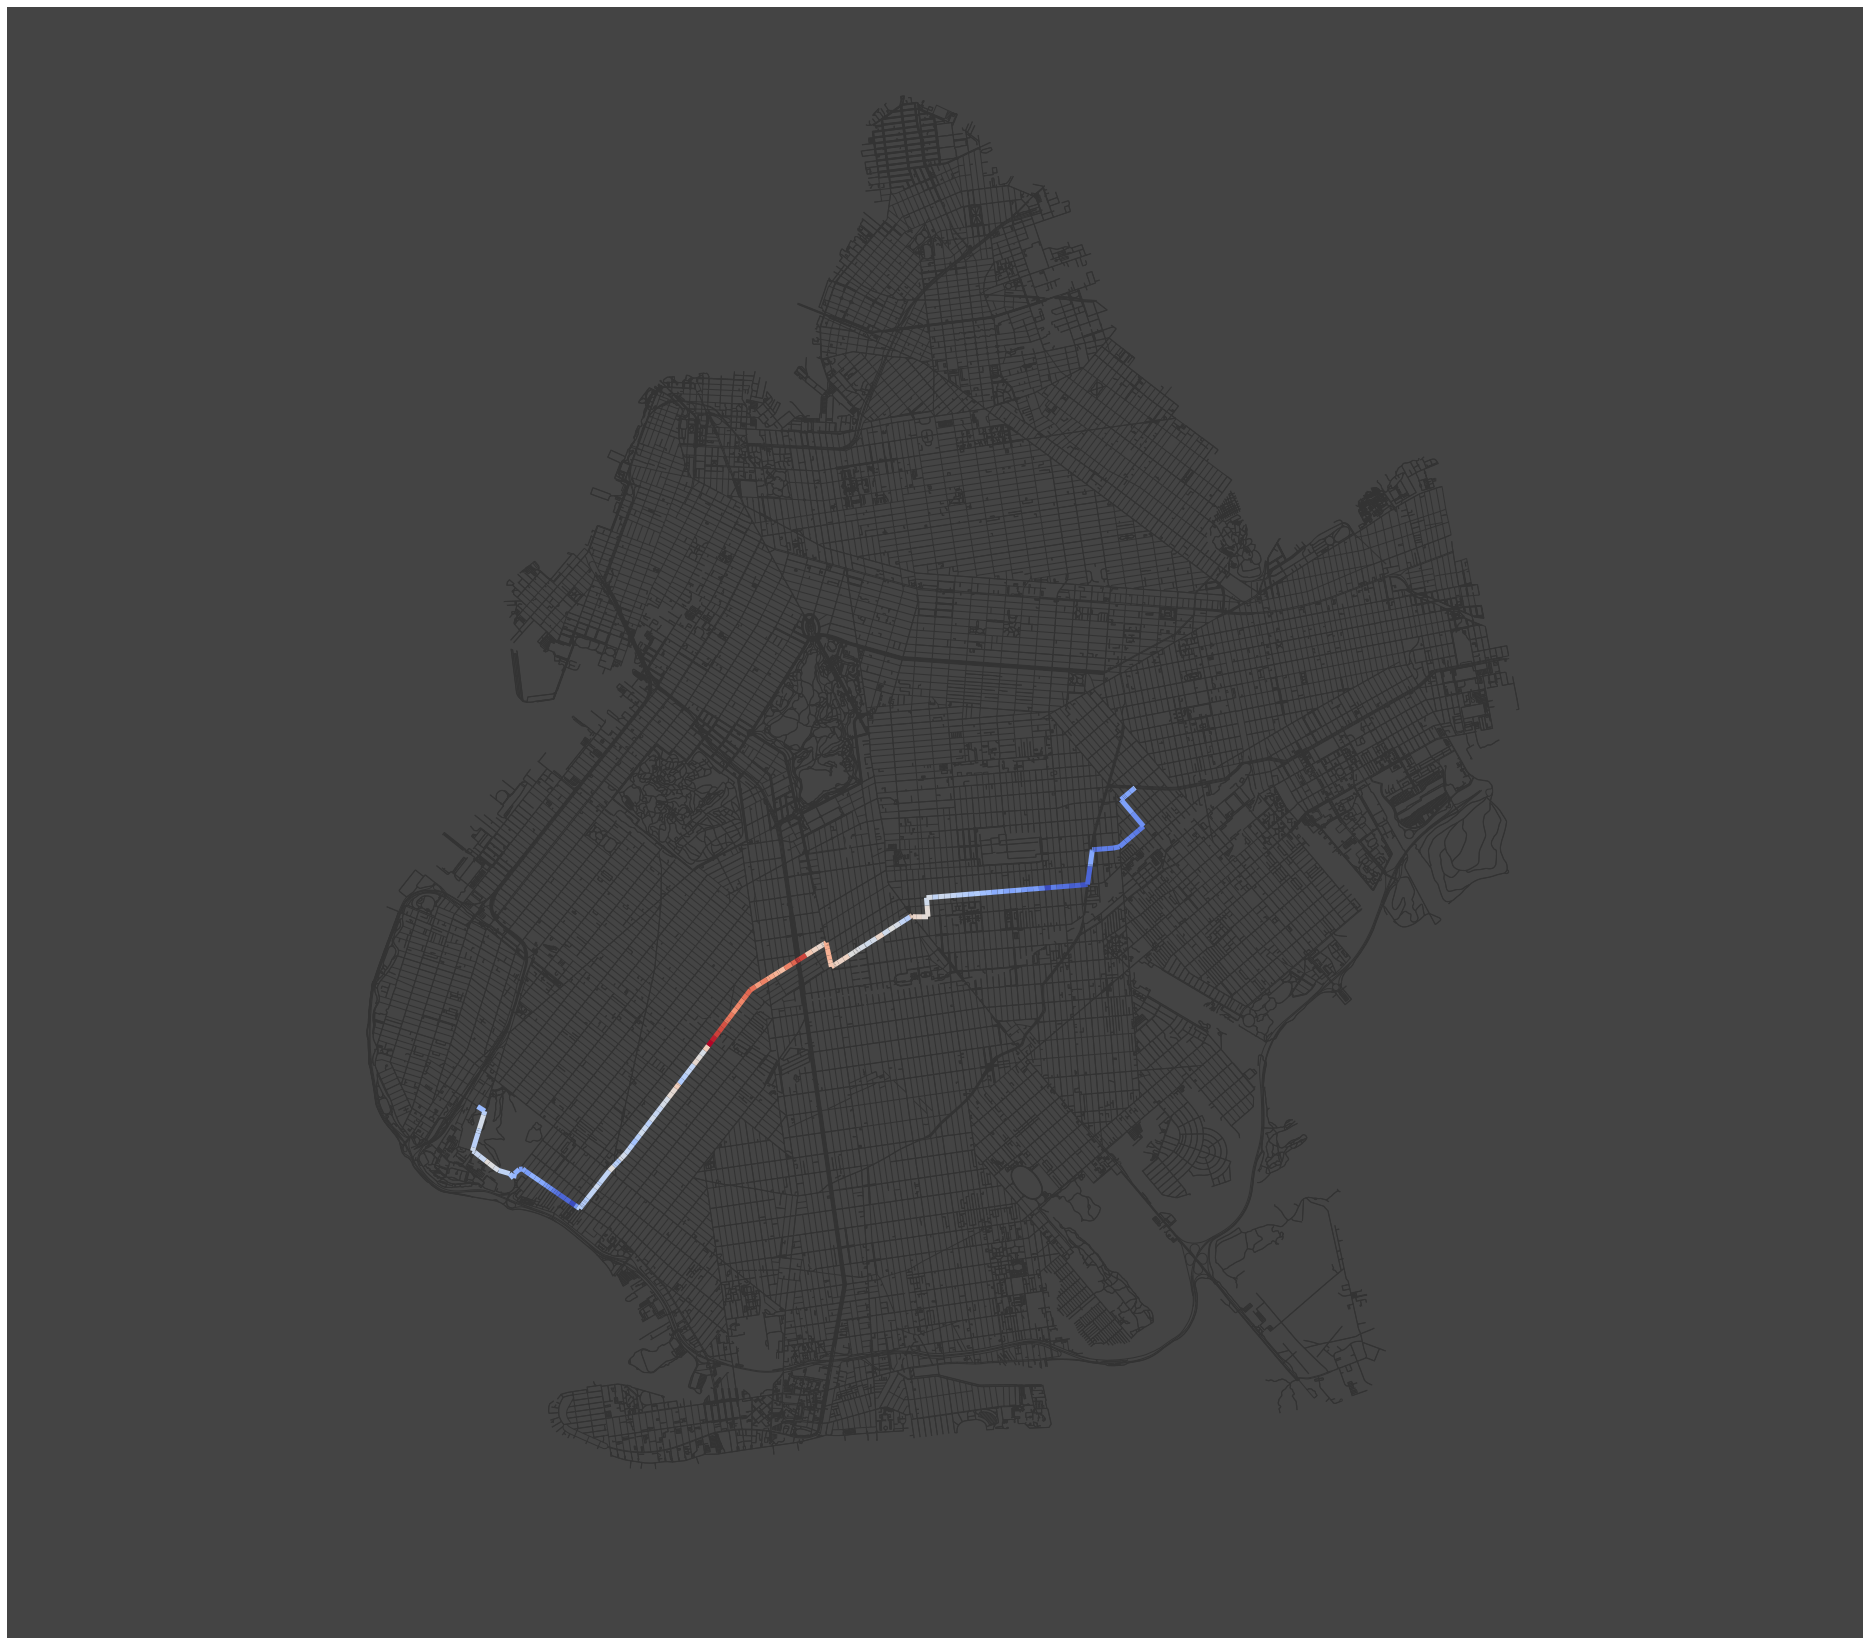

In [34]:
bbox=(40.75, 40.55, -73.80, -74.10)
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(bk, ax=ax, bgcolor='#444', node_size=0, bbox=bbox, show=False, close=False, edge_color='#333')

edge_colors = ox.plot.get_edge_colors_by_attr(route_subgraph, attr='weight', cmap='coolwarm')
ox.plot_graph(route_subgraph, ax=ax, bgcolor='#444', node_size=0, bbox=bbox, show=False, close=False, edge_color=edge_colors, edge_linewidth=5)
ax.set_facecolor('#444')
plt.show()